In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys, shutil
sys.path.append('../../../fastai')

# this file contains all the main external libs used
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
DS_PATH = '../../../datasets/in-or-out'
PATH = 'data/in-or-out'

# CLASSES = [ os.path.basename(d) for d in glob(os.path.join(DS_PATH, '*')) ]
CLASSES = ['in-n-out', 'not-in-n-out']

In [4]:
arch = resnet34
sz = 224
bsz = 64

## 1. Data preparation

In [ ]:
shutil.rmtree(f'{DS_PATH}/train')
shutil.rmtree(f'{DS_PATH}/test')
shutil.rmtree(f'{DS_PATH}/valid')
shutil.rmtree(f'{DS_PATH}/sample')

In [ ]:
g = glob(f'{DS_PATH}/*/*')

for f in g:
    img = PIL.Image.open(f)
    if (img.mode == 'P' and img.format == 'PNG' and not f.endswith('.jpg')):
        img = scipy.misc.imread(f, mode='RGBA')
        img = PIL.Image.fromarray(img)
        img.save(f)


In [ ]:
# remove gif and jpegs with weird transparency settings
g = glob(f'{DS_PATH}/*/*')
for f in g:
    img = PIL.Image.open(f)
    if (img.mode == 'P'):
        os.remove(f)

### Create train, validation, test, and sample dirs

In [ ]:
for d in CLASSES:
    os.makedirs(f'{DS_PATH}/train/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/valid/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/sample/train/{d}', exist_ok=True)
    os.makedirs(f'{DS_PATH}/sample/valid/{d}', exist_ok=True)
    
os.makedirs(f'{DS_PATH}/sample/test/unknown', exist_ok=True)
os.makedirs(f'{DS_PATH}/test/unknown', exist_ok=True)

### Move training, validation, and test data into appropriate sub-dirs

In [ ]:
# COPY images into /train directory
for d in CLASSES:
    for f in os.listdir(f'{DS_PATH}/{d}'): 
        if (not f.startswith('.')): shutil.copyfile(f'{DS_PATH}/{d}/{f}', f'{DS_PATH}/train/{d}/{f}')

In [ ]:
# MOVE a subset of /train images into /valid
g = glob(f'{DS_PATH}/train/*/*')
n_valid = int(len(g) * 0.2)

shuf = np.random.permutation(g)
for i in range(n_valid): os.rename(shuf[i], shuf[i].replace('train', 'valid'))

### Copy a small subset of training data into /sample dir

In [ ]:
# COPY a small subset of each class into /sample
g = glob(f'{DS_PATH}/train/*/*')

shuf = np.random.permutation(g)
for i in range(100): shutil.copyfile(shuf[i], shuf[i].replace('train', 'sample/train'))
    
shuf = np.random.permutation(g)
for i in range(50): shutil.copyfile(shuf[i], shuf[i].replace('train', 'sample/valid'))

## 2. Configure paths

In [ ]:
os.makedirs(f'{PATH}/models', exist_ok=True)
os.makedirs(f'{PATH}/tmp', exist_ok=True)

abs_ds_path = os.path.abspath(DS_PATH)

# symlink to root datasets so can use same data in other projects
!ln -s {abs_ds_path}/train {PATH}
!ln -s {abs_ds_path}/valid {PATH}
!ln -s {abs_ds_path}/test {PATH}
!ln -s {abs_ds_path}/sample {PATH}

## 3. Review Data

* TO DO

In [ ]:
g = glob(f'{PATH}/train/*/*')
size_d = {f: PIL.Image.open(f).size for f in g}

In [ ]:
row_sz, col_sz = list(zip(*size_d.values()))

In [ ]:
row_sz = np.array(row_sz); col_sz=np.array(col_sz)

In [ ]:
row_sz[:5]

In [ ]:
plt.hist(row_sz[row_sz<1000])
plt.show()
plt.hist(col_sz[col_sz<1000])
plt.show()

## 4. Training

**Review: easy steps to train a world-class image classifier:**
1. Enable data augmentation, and precompute=True
1. Use lr_find() to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use lr_find() again
1. Train full network with cycle_mult=2 until over-fitting

In [5]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}/tmp

In [6]:
# 1. Enable data augmentation, and precompute=True
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, bs=bsz, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


In [7]:
# 2. Use lr_find() to find highest learning rate where loss is still clearly improving
lrf = learn.lr_find()

A Jupyter Widget

 59%|█████▊    | 17/29 [00:00<00:00, 29.67it/s, loss=15.7] 


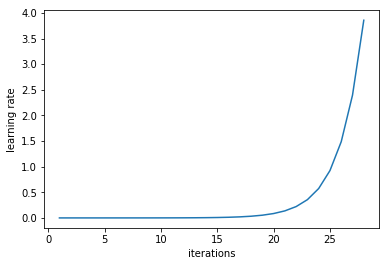

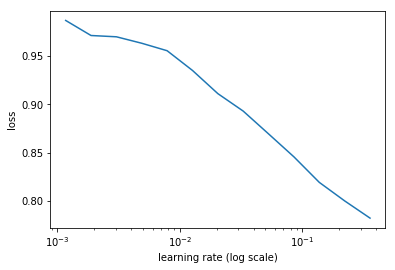

In [8]:
learn.sched.plot_lr()
plt.show()
learn.sched.plot()
plt.show()

In [9]:
# 3. Train last layer from precomputed activations for 1-2 epochs
learn.fit(1e-1, 2)

A Jupyter Widget

[ 0.       0.27264  0.63137  0.84961]                      
[ 1.       0.39814  0.51113  0.89987]                      



In [10]:
# 4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
learn.precompute = False
learn.fit(1e-1, 3, cycle_len=1)

A Jupyter Widget

[ 0.       0.21488  0.33602  0.91211]                      
[ 1.       0.26417  0.28485  0.9082 ]                      
[ 2.       0.29051  0.28327  0.91016]                      



In [11]:
# 5. Unfreeze all layers
learn.unfreeze()

A Jupyter Widget

 86%|████████▌ | 25/29 [00:45<00:07,  1.81s/it, loss=1.41] 

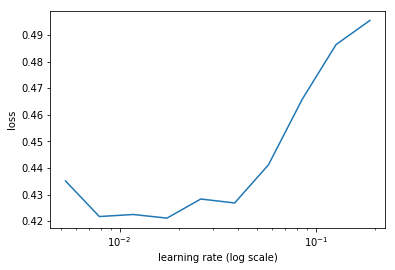

In [12]:
learn.lr_find(1e-1/1000)
learn.sched.plot()

In [13]:
# 6. Set earlier layers to 3x-10x lower learning rate than next higher layer
lr = np.array([1e-5, 1e-4, 1e-3])

In [14]:
# 8. Train full network with cycle_mult=2 until over-fitting
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

Exception in thread Thread-15:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



Exception in thread Thread-16:
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       0.18394  0.38729  0.8681 ]                      
[ 1.       0.25513  0.38284  0.87591]                      
[ 2.       0.28057  0.37625  0.87982]                      
[ 3.       0.28931  0.36418  0.87787]                      
[ 4.       0.29273  0.36133  0.88177]                      
[ 5.       0.28793  0.35464  0.87982]                      
[ 6.       0.27895  0.35858  0.87787]                      



In [15]:
log_preds, y = learn.TTA()
accuracy(log_preds, y)

0.91792656587472998

[[ 66  26]
 [ 12 359]]


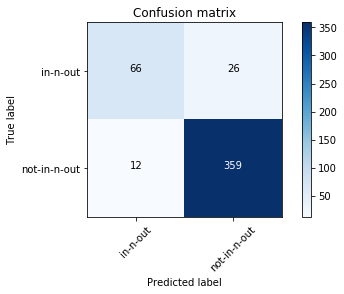

In [16]:
from sklearn.metrics import confusion_matrix

preds = np.argmax(log_preds, axis=1)
probs = np.exp(log_preds[:,1])

cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

In [17]:
learn.save('224_rn32_20171108')